*Тема курсовой работы:*

**Применение методов машинного обучения для классификации типов опухолевых клеток на гистологических изображениях**


наборы данных смотрела на этом сайте: https://paperswithcode.com/datasets?mod=medical&task=medical-image-segmentation&page=1

скачивала : https://academictorrents.com/details/27772adef6f563a1ecc0ae19a528b956e6c803ce



In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Загрузка датасета

https://zenodo.org/records/53169#.XGZemKwzbmG

Восемь классов:
  * 0: «опухолевый эпителий»,
  * 1: «простая строма»,
  * 2: «сложная строма» (строма, содержащая отдельные опухолевые клетки и/или отдельные иммунные клетки),
  * 3: «конгломераты иммунных клеток»,
  * 4: «обломки» и слизь»,
  * 5: «железы слизистой оболочки»,
  * 6: «жировая ткань» и
  * 7: «фон».

In [3]:
classes = {0: 'опухолевый эпителий',
           1: 'простая строма',
           2: 'сложная строма', # (строма, содержащая отдельные опухолевые клетки и/или отдельные иммунные клетки)
           3: 'конгломераты иммунных клеток',
           4: 'обломки» и слизь',
           5: 'железы слизистой оболочки',
           6: 'жировая ткань',
           7: 'фон'}
classes

{0: 'опухолевый эпителий',
 1: 'простая строма',
 2: 'сложная строма',
 3: 'конгломераты иммунных клеток',
 4: 'обломки» и слизь',
 5: 'железы слизистой оболочки',
 6: 'жировая ткань',
 7: 'фон'}

In [4]:
dataset0 = tfds.load('colorectal_histology', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/incomplete.0YUPII_2.0.0/colorectal_histology-train.tf…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [5]:
dataset = tfds.load('colorectal_histology', split='train')

In [6]:
dataset

<_PrefetchDataset element_spec={'filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(150, 150, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [7]:
for ex in dataset.take(1):
  print(ex['filename'])

tf.Tensor(b'160F4_CRC-Prim-HE-08_021.tif_Row_1201_Col_1651.tif', shape=(), dtype=string)


In [8]:
for example in dataset.take(1):
    image = example['image']
    label = example['label']
    print(f"Тип изображения: {type(image)}, Размер: {image.shape}")
    print(f"Метка: {label}")

Тип изображения: <class 'tensorflow.python.framework.ops.EagerTensor'>, Размер: (150, 150, 3)
Метка: 4


In [11]:
# def preprocess(example):
#     image = example['image']
#     label = example['label']
#     image = tf.image.resize(image, (224, 224))
#     image = tf.cast(image, tf.float32)
#     image = image / 255.0  # (для нормализации значений пикселей в диапазон [0, 1]).
#     return image, label

# # Применяем предобработку
# dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
# dataset

In [35]:
# Преобразование данных в списки
images = []
labels = []

for example in dataset:
    images.append(example['image'].numpy())
    labels.append(example['label'].numpy())

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [12]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # (для нормализации значений пикселей в диапазон [0, 1])
    return image, label

# Применение предобработки и батчинг
BATCH_SIZE = 32

train_dataset = train_dataset.map(preprocess).shuffle(len(train_images)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
for images, labels in train_dataset.take(1):
    print(f"Размер батча изображений: {images.shape}")
    print(f"Размер батча меток: {labels.shape}")

Размер батча изображений: (32, 150, 150, 3)
Размер батча меток: (32,)


In [14]:
for images, labels in test_dataset.take(1):
    print(f"Размер батча изображений: {images.shape}")
    print(f"Размер батча меток: {labels.shape}")

Размер батча изображений: (32, 150, 150, 3)
Размер батча меток: (32,)


In [15]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [16]:
# # Отображение 5 изображений
# plt.figure(figsize=(10, 10))
# for i, example in enumerate(train_dataset.take(5)):  # Берём первые 5 примеров
#     image = example['image']
#     label = example['label']
#     plt.subplot(1, 5, i + 1)
#     plt.imshow(image.numpy())
#     plt.title(f"Метка: {label.numpy()}")
#     plt.axis("off")
# plt.show()

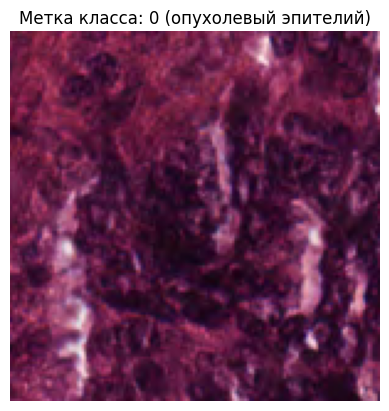

In [17]:
# Вывод одного батча из тренировочного набора
for images, labels in train_dataset.take(5):  # Берём один батч
    # Извлечение первого изображения и его метки
    image = images[0].numpy()  # Первое изображение в батче
    label = labels[0].numpy()  # Соответствующая метка
    break

# Отображение изображения
plt.imshow(image)
plt.title(f"Метка класса: {label} ({classes[label]})")
plt.axis("off")
plt.show()
# print(classes[label])

***Баланс классов***

In [45]:
# Получение уникальных классов и их частоты
unique, counts = np.unique(labels, return_counts=True)

# Вывод результатов
for label, count in zip(unique, counts):
    print(f'{label}: {count}')

0: 625
1: 625
2: 625
3: 625
4: 625
5: 625
6: 625
7: 625


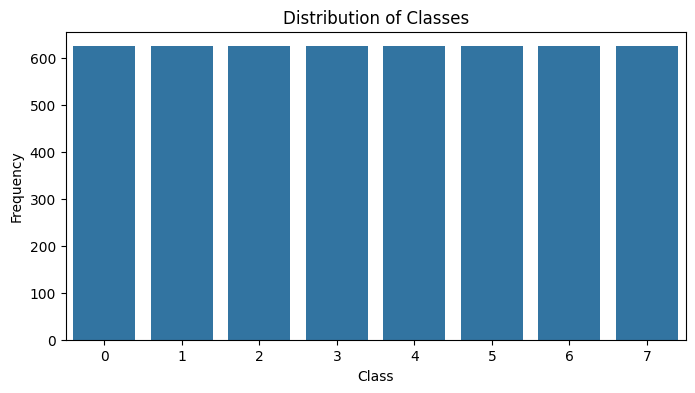

In [44]:
df = pd.DataFrame(labels, columns=['Class'])

# Визуализация
plt.figure(figsize=(8, 4))
sns.countplot(x='Class', data=df)

plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

Абсолютно сбалансированный набор данных

# Модели

## Простые базовые модели

In [ ]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
# test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

### Логистическая регрессия

In [50]:
train_images, train_labels = np.array(train_images), np.array(train_labels)
test_images, test_labels = np.array(test_images), np.array(test_labels)

In [ ]:
# Преобразование данных в 2D массив
X_train_reshaped = train_images.reshape(train_images.shape[0], -1)  # Преобразуем в (num_samples, height * width * channels)
X_test_reshaped = test_images.reshape(test_images.shape[0], -1)

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)
y_train = train_labels.copy()
y_test = test_labels.copy()


# Создание и обучение модели логистической регрессии
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train_scaled, y_train)


# Предсказания модели
y_pred_train_logistic = logistic_model.predict(X_train_scaled)  # Предсказания на тренировочной выборке
y_pred_test_logistic = logistic_model.predict(X_test_scaled)    # Предсказания на тестовой выборке

# Вычисление метрик для тренировочной выборки
logistic_accuracy_train = accuracy_score(y_train, y_pred_train_logistic)
logistic_precision_train = precision_score(y_train, y_pred_train_logistic, average='weighted')
logistic_recall_train = recall_score(y_train, y_pred_train_logistic, average='weighted')
logistic_f1_train = f1_score(y_train, y_pred_train_logistic, average='weighted')

# Вычисление метрик для тестовой выборки
logistic_accuracy_test = accuracy_score(y_test, y_pred_test_logistic)
logistic_precision_test = precision_score(y_test, y_pred_test_logistic, average='weighted')
logistic_recall_test = recall_score(y_test, y_pred_test_logistic, average='weighted')
logistic_f1_test = f1_score(y_test, y_pred_test_logistic, average='weighted')

# Вывод метрик
print("Логистическая регрессия (Тренировочная выборка):")
print(f"Точность (Accuracy): {logistic_accuracy_train:.4f}")
print(f"Точность (Precision): {logistic_precision_train:.4f}")
print(f"Полнота (Recall): {logistic_recall_train:.4f}")
print(f"F1-мера: {logistic_f1_train:.4f}")

print("\nЛогистическая регрессия (Тестовая выборка):")
print(f"Точность (Accuracy): {logistic_accuracy_test:.4f}")
print(f"Точность (Precision): {logistic_precision_test:.4f}")
print(f"Полнота (Recall): {logistic_recall_test:.4f}")
print(f"F1-мера: {logistic_f1_test:.4f}")

### K-ближайших соседей (KNN)

In [ ]:
# Создание и обучение модели K-ближайших соседей
k = 5  # Количество соседей
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train_scaled, y_train)

# Предсказания модели
y_pred_knn = knn_model.predict(X_test_scaled)

# Вычисление метрик
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_precision = precision_score(y_test, y_pred_knn, average='weighted')
knn_recall = recall_score(y_test, y_pred_knn, average='weighted')
knn_f1 = f1_score(y_test, y_pred_knn, average='weighted')

print("\nK-ближайших соседей:")
print(f"Точность (Accuracy): {knn_accuracy:.4f}")
print(f"Точность (Precision): {knn_precision:.4f}")
print(f"Полнота (Recall): {knn_recall:.4f}")
print(f"F1-мера: {knn_f1:.4f}")


## Глубокие нейронные сети

In [18]:
num_classes = len(classes)
# Создание модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # 8 классов
])

# Компиляция модели
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучение модели
EPOCHS = 10
history = model.fit(train_dataset, epochs=EPOCHS)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.3423 - loss: 2.3679
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.5413 - loss: 1.0418
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.6222 - loss: 0.8692
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.6691 - loss: 0.7960
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7098 - loss: 0.6946
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.7235 - loss: 0.6652
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.7285 - loss: 0.6252
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.7452 - loss: 0.5778
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.7635 - loss: 0.5466
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8044 - loss: 0.4643


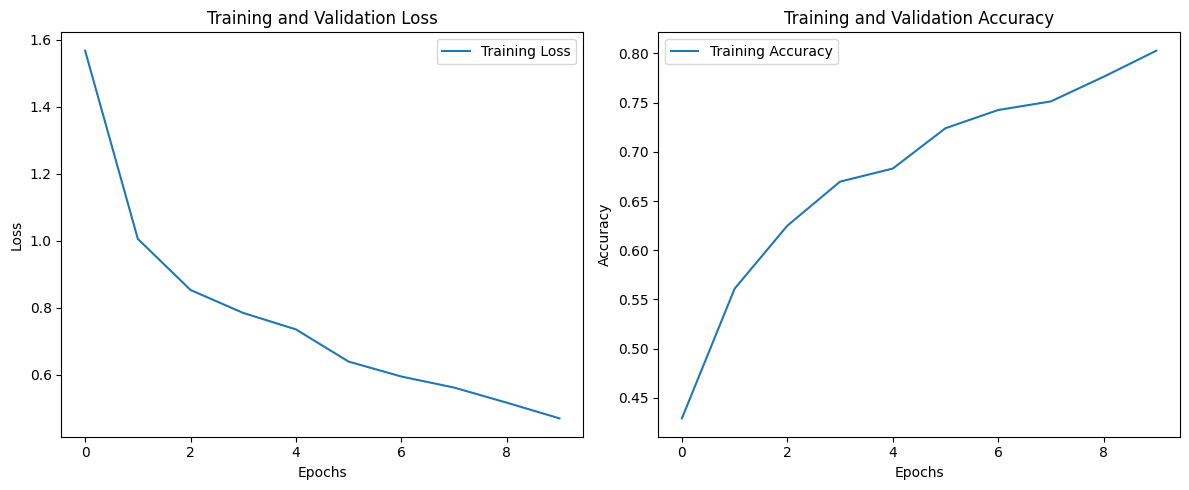

In [21]:
# Построение графиков потерь и точности
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
# Оценка модели на тестовой выборке
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Тестовые потери: {test_loss:.4f}")
print(f"Тестовая точность: {test_accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 356ms/step - accuracy: 0.7566 - loss: 0.6618
Тестовые потери: 0.7004
Тестовая точность: 0.7480


In [23]:
# Дообучение модели
EPOCHS = 2
history = model.fit(train_dataset, epochs=EPOCHS)

Epoch 1/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.8207 - loss: 0.4483
Epoch 2/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.8247 - loss: 0.4012


In [26]:
# Оценка модели на тестовой выборке
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Тестовые потери: {test_loss:.4f}")
print(f"Тестовая точность: {test_accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 398ms/step - accuracy: 0.7826 - loss: 0.6686
Тестовые потери: 0.7112
Тестовая точность: 0.7780


In [29]:
# Дообучение модели
EPOCHS = 10
history = model.fit(train_dataset, epochs=EPOCHS)

# Оценка модели на тестовой выборке
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Тестовые потери: {test_loss:.4f}")
print(f"Тестовая точность: {test_accuracy:.4f}")

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.8486 - loss: 0.3806
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.8320 - loss: 0.3937
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.8290 - loss: 0.4070
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.8476 - loss: 0.3520
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8752 - loss: 0.3171
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.8657 - loss: 0.3004
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8820 - loss: 0.2852
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.8874 - loss: 0.2789
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.8883 - loss: 0.2738
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.8881 - loss: 0.2781
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.7586 - loss: 0.9188
Тестовые потери: 0.9742
Тестовая точность: 0.7580


32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 379ms/step


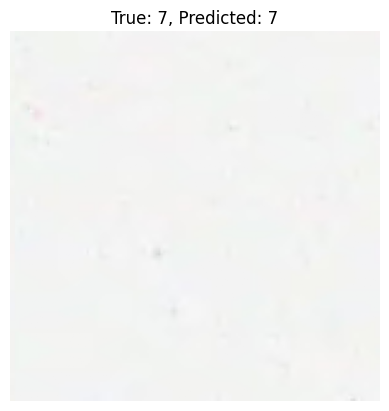

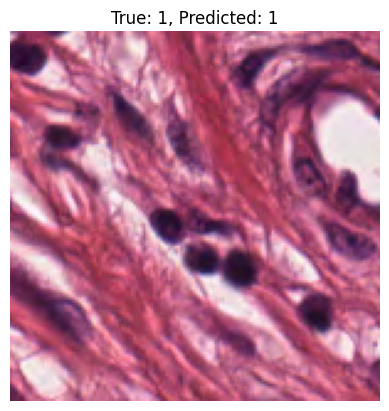

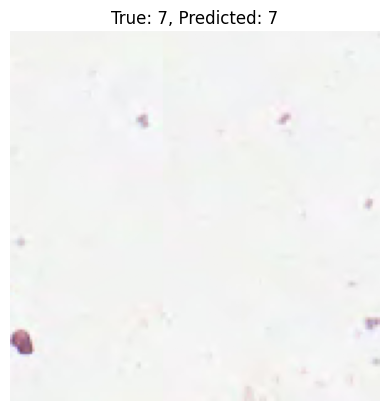

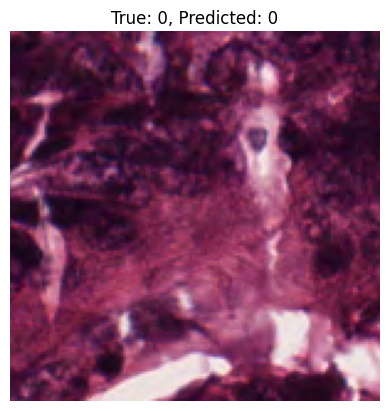

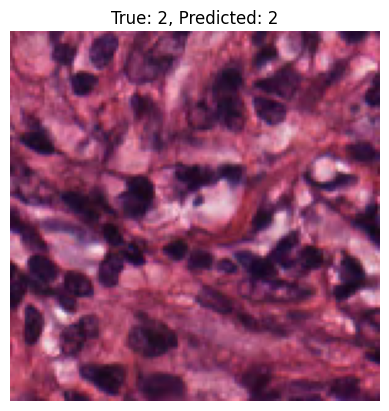

In [30]:
# Предсказания модели на тестовых данных
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)  # Предсказанный класс

# Пример визуализации первых 5 изображений и предсказаний
import matplotlib.pyplot as plt

for images, labels in test_dataset.take(1):  # Берем 1 батч
    for i in range(5):
        plt.imshow(images[i])
        plt.title(f"True: {labels[i].numpy()}, Predicted: {predicted_classes[i]}")
        plt.axis('off')
        plt.show()
